# EDA: RAW Pokémon data from MongoDB

Exploratory Data Analysis (EDA) sobre los datos RAW de Pokémon guardados en MongoDB por la etapa EXTRACT.

- Origen de datos: colección `pokemon_raw` en MongoDB (JSON crudo de la PokeAPI).
- Tamaño de muestra: depende de `POKEAPI_LIMIT` en `.env` (este notebook usa los datos ya extraídos).
- Métricas numéricas analizadas: `height`, `weight`, `base_experience`.
  - Nota de unidades (PokeAPI): `height` en decímetros (~0.1 m) y `weight` en hectogramos (~0.1 kg).
- Distribuciones: tipos primarios (conteo), con visualizaciones de barras y de torta (pie chart).
- Objetivo didáctico: análisis simple y claro para comprender la forma/escala de los datos RAW antes de transformar/cargar.


## Resumen ejecutivo e índice

- Este notebook documenta el EDA de datos RAW de Pokémon obtenidos de la PokeAPI (vía colección `pokemon_raw` en MongoDB).
- Se describen variables numéricas (`height`, `weight`, `base_experience`) y categóricas (`primary_type`).
- Se incluyen visualizaciones: barras de tipos, histogramas, dispersión altura–peso y una torta de proporciones.
- En todo momento se respetan las unidades de la PokeAPI, aclarando sus conversiones a SI (m, kg).
- Este EDA es descriptivo y no realiza transformaciones agresivas ni limpieza profunda; busca entender la forma de los datos crudos.

### Índice
- Contexto y reproducibilidad
- Definiciones y transformaciones mínimas
- Estadísticas descriptivas (cómo leerlas)
- Distribución de tipos primarios (barras)
- Histogramas de variables numéricas
- Relación altura vs peso (dispersión + tendencia)
- Proporción de tipos primarios (torta)
- Limitaciones y próximos pasos

In [1]:
# Configuration and connection to MongoDB
from dotenv import load_dotenv
from pymongo import MongoClient
import os

load_dotenv()  # load .env variables if present
MONGO_URI = os.getenv('MONGO_URI', 'mongodb://localhost:27017')
MONGO_DB = os.getenv('MONGO_DB', 'etl_demo')
MONGO_RAW_COLLECTION = os.getenv('MONGO_RAW_COLLECTION', 'pokemon_raw')

client = MongoClient(MONGO_URI)
db = client[MONGO_DB]
raw_col = db[MONGO_RAW_COLLECTION]
raw_col

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'etl_demo'), 'pokemon_raw')

### Contexto y reproducibilidad

- **Origen de datos**: colección `pokemon_raw` en MongoDB con documentos JSON de la PokeAPI.
- **Precondiciones**: la fase de extracción ya ejecutó y pobló la colección.
- **Variables de entorno**:
  - `MONGO_URI`: URL de conexión (por defecto `mongodb://localhost:27017`).
  - `MONGO_DB`: base de datos (por defecto `etl_demo`).
  - `MONGO_RAW_COLLECTION`: colección RAW (por defecto `pokemon_raw`).
  - `POKEAPI_LIMIT`: tamaño de muestra en la extracción (impacta distribuciones).
- **Reproducibilidad**:
  - Fijar `POKEAPI_LIMIT` y mantener la misma versión de PokeAPI evita cambios de muestra.
  - Documentar la fecha de extracción y versión del esquema si cambia el upstream.
  - Guardar seeds no aplica directamente aquí; el muestreo es determinista dado el pipeline.
- **Validaciones rápidas**:
  - Comprobar conexión y conteo de documentos.
  - Verificar campos clave presentes: `types`, `height`, `weight`, `base_experience`.

In [2]:
# Load data into a DataFrame (pandas) for a simple EDA
import pandas as pd

docs = list(raw_col.find({}, {'_id': 0, 'types': 1, 'height': 1, 'weight': 1, 'base_experience': 1}))
df = pd.DataFrame(docs)

# Derive primary type and convert units to SI for better interpretation
# height: dm -> m, weight: hg -> kg
if 'types' in df.columns:
    def _primary_type(lst):
        if isinstance(lst, list) and len(lst) > 0:
            t0 = sorted(lst, key=lambda x: x.get('slot', 99))[0]
            return (t0.get('type') or {}).get('name')
        return None
    df['primary_type'] = df['types'].apply(_primary_type)

df['height_m'] = pd.to_numeric(df.get('height'), errors='coerce') / 10
df['weight_kg'] = pd.to_numeric(df.get('weight'), errors='coerce') / 10

total = len(df)
print('Total RAW Pokemon:', total)
df.head(3)

Total RAW Pokemon: 25


,base_experience,height,types,weight,primary_type,height_m,weight_kg
0,64,7,"[{'slot': 1, 'type': {'name': 'grass', 'url': ...",69,grass,0.7,6.9
1,142,10,"[{'slot': 1, 'type': {'name': 'grass', 'url': ...",130,grass,1.0,13.0
2,236,20,"[{'slot': 1, 'type': {'name': 'grass', 'url': ...",1000,grass,2.0,100.0


### Definiciones y transformaciones mínimas

- **`primary_type`**: se deriva del primer elemento de `types` (slot más bajo). Si no existe `types` o está vacío, se asigna `None`.
- **Conversión de unidades**:
  - `height_m` = `height` / 10 (dm → m).
  - `weight_kg` = `weight` / 10 (hg → kg).
- **Coerción a numérico**: se usa `pd.to_numeric(..., errors='coerce')` para forzar tipos numéricos y convertir valores inválidos a `NaN`.
- **`NaN` y valores faltantes**:
  - Columnas numéricas: se omiten en cálculos (p. ej., `dropna()` en histogramas).
  - Columnas categóricas: las ausencias no se cuentan; conviene revisarlas si son frecuentes.
- **Sugerencias**:
  - Verificar outliers en `height_m` y `weight_kg` (p. ej., puntos extremadamente altos/bajos pueden ser especies especiales).

In [3]:
# Estadísticas con pandas (describe)
numeric = df[['height_m','weight_kg','base_experience']]
print('Total RAW Pokémon:', len(df))
numeric.describe().round(2)

Total RAW Pokémon: 25


,height_m,weight_kg,base_experience
count,25.00,25.00,25.00
mean,1.02,26.14,121.04
std,0.74,29.11,67.17
min,0.30,1.80,39.00
25%,0.50,6.90,62.00
50%,1.00,13.00,122.00
75%,1.20,32.00,157.00
max,3.50,100.00,240.00


## Vista rápida: propósito y lectura

- **Objetivo**: confirmar que las transformaciones mínimas quedaron en columnas claras (`primary_type`, `height_m`, `weight_kg`, `base_experience`).
- **Cómo leer**: inspección visual de primeras filas ayuda a detectar valores nulos, escalas incorrectas o etiquetas inesperadas.
- **Acción**: si `primary_type` trae `None` con frecuencia, revisar la derivación desde `types` y los `slot`.

In [4]:
# Vista rápida de los datos transformados en columnas útiles
# (tipo primario + variables numéricas en SI)
df[['primary_type','height_m','weight_kg','base_experience']].head()

,primary_type,height_m,weight_kg,base_experience
0,grass,0.7,6.9,64
1,grass,1.0,13.0,142
2,grass,2.0,100.0,236
3,fire,0.6,8.5,62
4,fire,1.1,19.0,142


## Distribución de tipos primarios (barras)

- **Objetivo**: visualizar los tipos más frecuentes y detectar concentración o cola larga.
- **Cómo leer**:
  - Comparar alturas de barras: mayores = más frecuentes en la muestra.
  - Revisar si hay dominio de pocos tipos vs. distribución balanceada.
  - Notar categorías ausentes: puede ser por tamaño de muestra (`POKEAPI_LIMIT`).
- **Buenas prácticas**:
  - Limitar a top-k para legibilidad (aquí top 10).
  - Si hay `None` en `primary_type`, revisar la extracción/parsing de `types`.
- **Acciones sugeridas**: si un tipo domina, evaluar estratificación de la muestra para análisis posteriores.

## Interpretación de las estadísticas

- **Cómo leer `describe()`**:
  - `count`: cantidad de observaciones válidas (no nulas).
  - `mean` y `std`: media y desviación estándar; compararlas ayuda a detectar dispersión elevada.
  - `min`, `25%`, `50%` (mediana), `75%`, `max`: resumen de la distribución por cuantiles; grandes saltos entre cuantiles sugieren asimetría.
- **Unidades**:
  - `height_m` en metros (dm/10) y `weight_kg` en kg (hg/10); comparar siempre en la misma escala SI.
- **Señales de calidad**:
  - `count` bajo vs total de filas sugiere datos faltantes; conviene rastrear origen (`types`, `height`, `weight`).
  - `max` o `min` extremos pueden corresponder a especies especiales o errores; validar contra la PokeAPI.
- **`base_experience`**: indicador simple de experiencia; no es una métrica de poder “oficial”, pero útil para contraste descriptivo.
- **Muestra**: depende de `POKEAPI_LIMIT`. Para estabilidad de resultados, aumentar el tamaño y repetir el EDA.

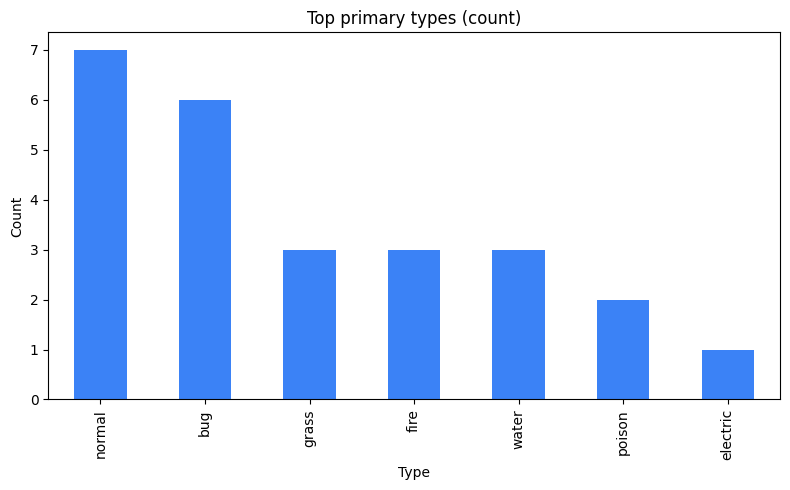

primary_type
normal      7
bug         6
grass       3
fire        3
water       3
poison      2
electric    1
Name: count, dtype: int64

In [5]:
# Barras: top 10 tipos primarios (pandas)
import matplotlib.pyplot as plt

top = df['primary_type'].value_counts().head(10)
ax = top.plot(kind='bar', color='#3B82F6', figsize=(8, 5))
ax.set_title('Top primary types (count)')
ax.set_xlabel('Type')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

top

## Histogramas de variables numéricas

- **Objetivo**: entender la forma de las distribuciones, asimetrías y outliers.
- **Parámetros clave**:
  - `bins`: controla el nivel de detalle; más bins revelan multimodalidad pero pueden introducir ruido.
  - Escala: si hay cola larga, considerar eje x logarítmico o winsorización para visualización.
- **Cómo interpretar**:
  - Picos múltiples sugieren subpoblaciones (p. ej., líneas evolutivas distintas).
  - Cola derecha pronunciada en `weight_kg` puede indicar especies muy pesadas; validar contra PokeAPI.
  - Diferencias entre mediana y media (ver `describe`) confirman asimetría.
- **Buenas prácticas**:
  - Usar `dropna()` evita sesgos por missing.
  - Comparar histogramas con boxplots para detectar outliers con más claridad.
  - Evitar `SELECT *` mental: enfocarse en variables relevantes y sus unidades.
- **Acciones sugeridas**:
  - Si hay outliers, marcar ids para revisar su origen.
  - Evaluar transformaciones (log) en pesos/alturas para modelos posteriores.

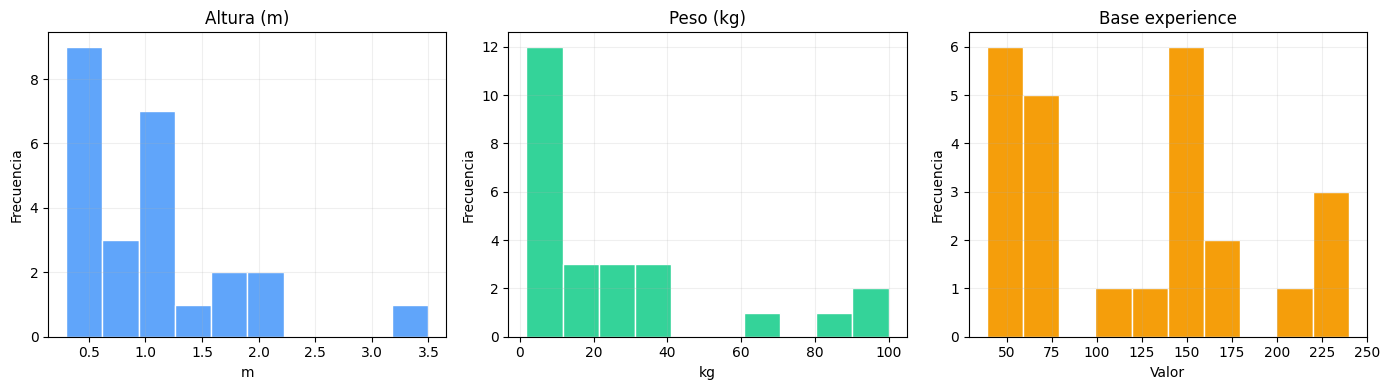

In [6]:
# Histogramas de height (m), weight (kg) y base_experience (pandas)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

df['height_m'].dropna().plot(kind='hist', bins=10, color='#60A5FA', edgecolor='white', ax=axes[0])
axes[0].set_title('Altura (m)')
axes[0].set_xlabel('m')
axes[0].set_ylabel('Frecuencia')

df['weight_kg'].dropna().plot(kind='hist', bins=10, color='#34D399', edgecolor='white', ax=axes[1])
axes[1].set_title('Peso (kg)')
axes[1].set_xlabel('kg')
axes[1].set_ylabel('Frecuencia')

pd.to_numeric(df['base_experience'], errors='coerce').dropna().plot(
    kind='hist', bins=10, color='#F59E0B', edgecolor='white', ax=axes[2]
)
axes[2].set_title('Base experience')
axes[2].set_xlabel('Valor')
axes[2].set_ylabel('Frecuencia')

for ax in axes:
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

## Gráfica de torta (pie) de tipos primarios

El diagrama de torta resume la proporción de tipos primarios en la muestra.
Para mantenerlo legible, agrupamos categorías muy pequeñas en "Others" si hay muchas etiquetas.

## Relación altura vs peso

- **Objetivo**: explorar asociación entre `height_m` y `weight_kg` y detectar posibles outliers.
- **Cómo leer**:
  - Patrón ascendente sugiere relación positiva (más altos → más pesados).
  - Puntos alejados de la nube principal pueden ser especies atípicas o errores.
  - La línea de tendencia (ajuste lineal) es un resumen simple; verificar robustez si hay outliers.
- **Buenas prácticas**:
  - Considerar escalas logarítmicas si hay colas largas.
  - Probar correlación de Spearman (robusta a asimetrías) además de Pearson.
- **Acciones sugeridas**:
  - Listar ids de outliers y validarlos contra la PokeAPI.
  - Segmentar por `primary_type` para ver si la pendiente varía entre grupos.

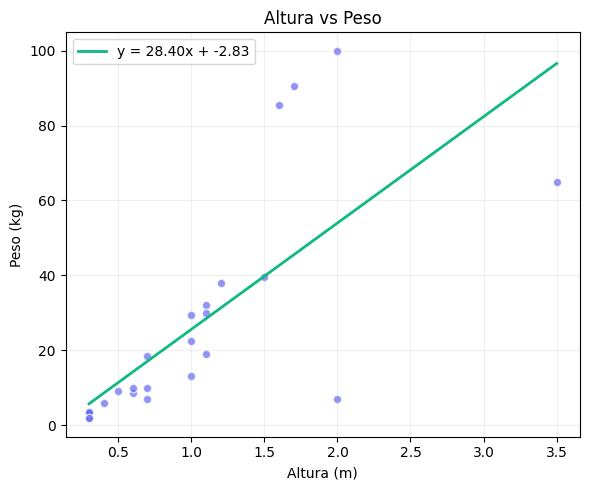

In [7]:
# Scatter: altura (m) vs peso (kg) con ajuste lineal (pandas/numpy)
import matplotlib.pyplot as plt
import numpy as np

mask = df['height_m'].notna() & df['weight_kg'].notna()
x = df.loc[mask, 'height_m'].astype(float).values
y = df.loc[mask, 'weight_kg'].astype(float).values

plt.figure(figsize=(6, 5))
plt.scatter(x, y, alpha=0.7, color='#6366F1', edgecolor='white')
plt.xlabel('Altura (m)')
plt.ylabel('Peso (kg)')
plt.title('Altura vs Peso')

# Ajuste lineal simple si hay suficientes puntos
if len(x) >= 2:
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 50)
    ys = m * xs + b
    plt.plot(xs, ys, color='#10B981', linewidth=2, label=f'y = {m:.2f}x + {b:.2f}')
    plt.legend()

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### Nota técnica: cálculo de `counter` para el pie chart

- Construimos un `Counter` con los valores de `primary_type` (omitiendo `NaN`).
- Este objeto permite obtener `most_common(k)` para seleccionar las categorías más frecuentes.
- Si hay muchas categorías, el gráfico agrupa las menos frecuentes en "Others" para mantener legibilidad.

In [8]:
# Support for pie chart: build `counter` of primary types
from collections import Counter

# Use `primary_type` values dropping nulls
counter = Counter(df['primary_type'].dropna())
counter.most_common(5)  # quick preview

[('normal', 7), ('bug', 6), ('grass', 3), ('fire', 3), ('water', 3)]

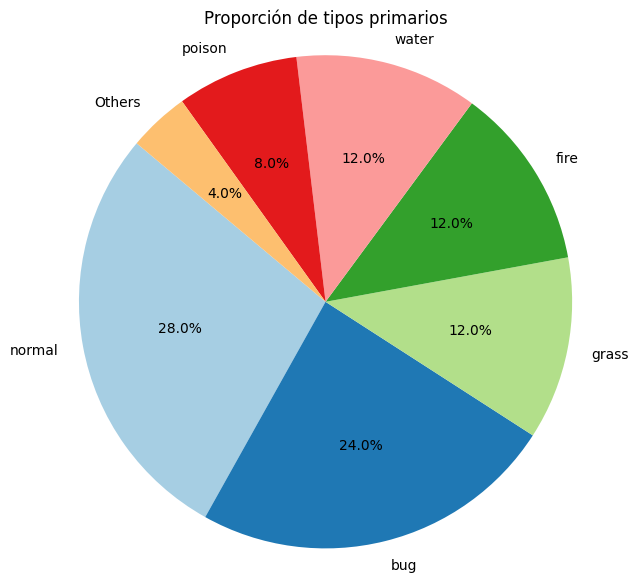

In [9]:
# Pie chart de tipos primarios (con "Others" si aplica)
import matplotlib.pyplot as plt

pairs = counter.most_common(10)
if pairs:
    labels, values = zip(*pairs)
    labels = list(labels)
    values = list(values)

    # Si hay muchas categorías, agrupar las menos frecuentes en "Others"
    max_slices = 6
    if len(labels) > max_slices:
        keep_labels = labels[:max_slices]
        keep_values = values[:max_slices]
        others = sum(values[max_slices:])
        keep_labels.append('Others')
        keep_values.append(others)
        labels, values = keep_labels, keep_values

    plt.figure(figsize=(7, 7))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title('Proporción de tipos primarios')
    plt.axis('equal')  # círculo perfecto
    plt.show()
else:
    print('No hay tipos para graficar.')

## Limitaciones y próximos pasos

- **Limitaciones**:
  - Muestra dependiente de `POKEAPI_LIMIT` y del orden de extracción; puede sesgar frecuencias de tipos.
  - Solo se deriva `primary_type`; tipos secundarios no analizados en este EDA (podrían alterar proporciones).
  - EDA descriptivo: no se imputan faltantes ni se corrigen outliers; solo se señalan.
  - Unidades convertidas a SI; validar valores extremos con la PokeAPI para descartar errores.
- **Próximos pasos**:
  - Incrementar `POKEAPI_LIMIT` y realizar paginado para una cobertura más amplia.
  - Revisar outliers (listar ids) y contrastar con documentación oficial.
  - Analizar `secondary_type` y combinaciones de tipos.
  - Probar transformaciones logarítmicas y estandarización para futuros modelos.
  - Segmentar por familias evolutivas o generaciones si se dispone de metadata adicional.